In [ ]:
import sys
from config import *

sys.path.append(f"{ROOT}")
PATH = "/home/malbranke/mutation_data"

In [2]:
import pandas as pd
import sys, os, re
import warnings
import numpy as np
from tqdm import tqdm
import pickle
from config import *
from data_extraction.utils import *

import seaborn as sns
sns.set(style="whitegrid", palette="muted")

sys.path.append(f"{ROOT}")
PATH = "/home/malbranke/mutation_data"
warnings.filterwarnings("ignore")

In [22]:
data = pickle.load(open(f"{DATA}/secondary_structure/training_set", "rb"))

bboxes = []
for _, sse in tqdm(data.values()):
    ss = to_onehot(sse, (None, 3))
    ss = np.pad(ss, ((1, 1), (0, 0)), "constant")
    dss = (ss[1:] - ss[:-1])
    cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
    bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
    bboxes.append(bbox)

100%|██████████| 8678/8678 [00:01<00:00, 8082.98it/s]


In [ ]:
pi = np.zeros(4)
pi[:3] = np.array([x[0, 2:] for x in bboxes]+[x[-1, 2:] for x in bboxes]).sum(0)

T_ = [np.append(x[:-1, 2:],x[1:, 2:], axis = 1) for x in bboxes]
T_ = np.concatenate(T_, axis = 0)

T = np.zeros((4,4))
for i in range(3):
    t = T_[np.where(T_[:,i] == 1)[0], 3:]
    T[i,:3] = t.sum(0)
    T[i,3] = pi[i]
    T[i] /= T[i].sum() 
T[3,3] = 1
T = T.reshape(4,4,1,1)

In [ ]:
bboxes_sp = [np.concatenate([x[np.where(x[:, 2]==1)[0]][:, :2] for x in bboxes], axis=0),
             np.concatenate([x[np.where(x[:, 3]==1)[0]][:, :2] for x in bboxes], axis=0),
             np.concatenate([x[np.where(x[:, 4]==1)[0]][:, :2] for x in bboxes], axis=0)]

Q_ = np.zeros((3, 100))
for i in range(3):
    Q_[i] = plt.hist(bboxes_sp[i][:,1] - bboxes_sp[i][:,0], bins = np.linspace(0, 100, 101)-0.5)[0]
    Q_[i] /= Q_[i].sum()
    
    Q = np.zeros((4,500,500))

for j in range(500):
    Q[:3,j, j:min(j+100, 500)] = Q_[:, :min(j+100, 500)-j]
Q[3, np.arange(500), np.arange(500)] = 1
Q = Q.reshape((1,4,500,500))

Q = torch.tensor(np.log(Q)+np.log(T))
pi = torch.tensor(np.log(pi/pi.sum()).reshape(-1,1))
torch.save(pi, "pi.pt")
torch.save(Q, "Q.pt")

In [78]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

In [5]:
rho_df.head(5)

,fam,dataset,exp,in_pdb,size,length,independent,epistatic,dot,dot_ind,dot_epi,matching,matching_ind,matching_epi,interpolate_epi,t,combine_epi
name,,,,,,,,,,,,,,,,,
Shakhnovich2012_Tm,DYR_ECOLI,Shakhnovich2012,Tm,1,16,159,0.644118,0.588235,0.600000,0.680000,0.780000,0.720000,0.660000,0.760000,0.040000,0.65,0.760000
Shakhnovich2012_fitness_30,DYR_ECOLI,Shakhnovich2012,fitness_30,1,28,159,0.416427,0.422450,0.378728,0.508571,0.457143,0.334536,0.548571,0.542857,0.010574,0.96,0.320000
Shakhnovich2012_fitness_37,DYR_ECOLI,Shakhnovich2012,fitness_37,1,28,159,0.182316,0.127019,0.368571,0.438403,0.502857,0.414286,0.309322,0.402857,0.128571,0.74,0.457143
Shakhnovich2012_fitness_42,DYR_ECOLI,Shakhnovich2012,fitness_42,1,28,159,0.076123,0.116648,0.462857,0.518478,0.288571,0.194286,0.428571,0.343247,0.008571,0.90,0.611429
Shakhnovich2012_abundance_30,DYR_ECOLI,Shakhnovich2012,abundance_30,1,28,159,0.610647,0.638566,0.477143,0.548571,0.368571,0.614286,0.548571,0.637143,0.314286,0.97,0.545714


In [198]:
rho_df = pd.read_csv(f"{PATH}/rho_df_randomforest.csv", index_col = 0)
cols = ['independent','epistatic', 'dot', 'dot_ind', 'dot_epi', 'matching', 'matching_ind',
       'matching_epi', 'interpolate_epi', 'combine_epi']
rho_df[cols] = np.abs(rho_df[cols])

grouper = rho_df.groupby("dataset")
rho_df2 = grouper.first()[["fam","exp","in_pdb","size","length"]]
for c in cols:
    rho_df2[c] = grouper.max(c)[c]
rho_df2["best"] = rho_df2[cols[2:]].max(1)
rho_df2 = rho_df2.sort_values("best")
rho_df2 = rho_df2.reset_index()

In [199]:
names = ["Independant", "Epistatic", "Dot Product", "Dot Product + Independant", "Dot Product + Epistatic",
         "Pattern Matching", "Pattern Matching + Independant", "Pattern Matching + Epistatic",
         "Interpolation", "Pattern Matching + Dot Product + Epistatic"]

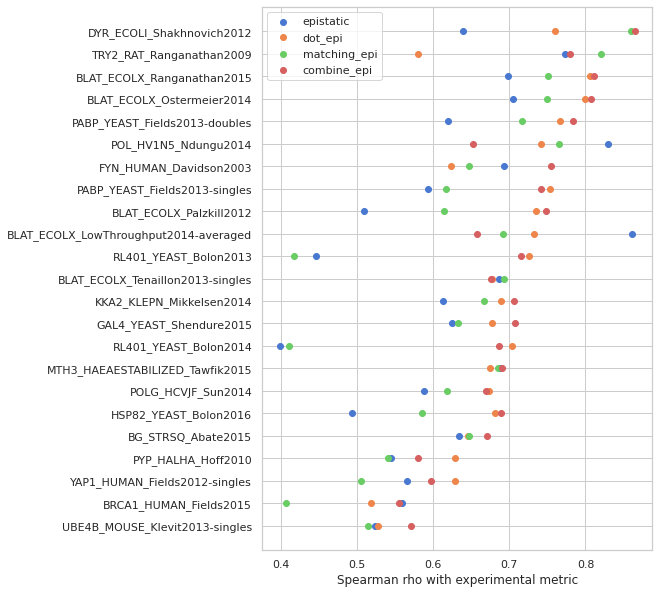

In [235]:
plt.figure(figsize = (7,10))
plt.scatter(rho_df2["epistatic"], rho_df2["epistatic"].index)
plt.scatter(rho_df2["dot_epi"],rho_df2["dot_epi"].index)
plt.scatter(rho_df2["matching_epi"], rho_df2["matching_epi"].index)
plt.scatter(rho_df2["combine_epi"], rho_df2["combine_epi"].index)

plt.legend(["epistatic", "dot_epi", "matching_epi", "combine_epi"])
plt.yticks(rho_df2.index, [f"{fam}_{name_dataset}" for fam, name_dataset in zip(rho_df2.fam.values,rho_df2.dataset.values)])
plt.xlabel("Spearman rho with experimental metric")
plt.savefig(f"{PATH}/mutational_prediction.png")
plt.show()

In [205]:
import random

cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#56ae57', 
       '#efb435', '#d3b683', '#c9d179', '#9d0759', "orange", "red"]
random.shuffle(cols)
color = {k:v for k,v in zip(rho_df.fam.unique(), cols)}


In [206]:
rho_df = rho_df.dropna()
len(rho_df.fam.unique())

17

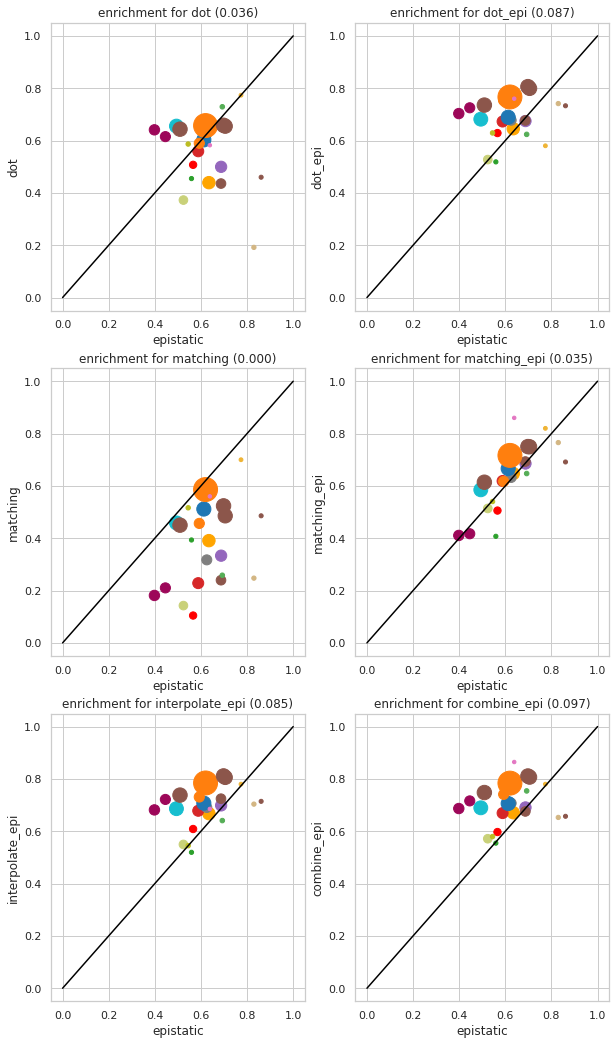

Text(0.5, 1.0, 'enrichment for best (0.108)')

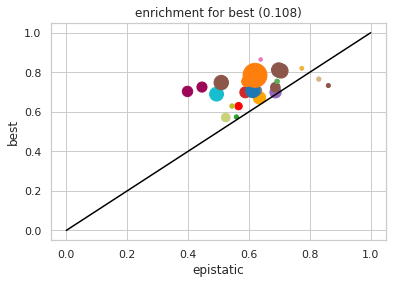

In [207]:
plt.figure(figsize = (10,18))

plt.subplot(3,2,1)
plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["dot"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("dot")
plt.title(f'enrichment for dot ({(rho_df2["dot"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')

plt.subplot(3,2,2)
plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["dot_epi"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("dot_epi")
plt.title(f'enrichment for dot_epi ({(rho_df2["dot_epi"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')

plt.subplot(3,2,3)
plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["matching"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("matching")
plt.title(f'enrichment for matching ({(rho_df2["matching"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')

plt.subplot(3,2,4)
plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["matching_epi"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("matching_epi")
plt.title(f'enrichment for matching_epi ({(rho_df2["matching_epi"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')

plt.subplot(3,2,5)
plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["interpolate_epi"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("interpolate_epi")
plt.title(f'enrichment for interpolate_epi ({(rho_df2["interpolate_epi"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')

plt.subplot(3,2,6)
plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["combine_epi"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("combine_epi")
plt.title(f'enrichment for combine_epi ({(rho_df2["combine_epi"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')


plt.show()

plt.plot([0,1], c="black")
plt.scatter(rho_df2["epistatic"], rho_df2["best"], c = rho_df2.fam.apply(lambda x : color[x]).values, 
            s = 3*np.sqrt(rho_df2["size"]), 
            marker = "o")
plt.xlabel("epistatic")
plt.ylabel("best")
plt.title(f'enrichment for best ({(rho_df2["best"]-rho_df2["epistatic"]).clip(0,1).mean():.3f})')


Text(0.5, 1.0, 'Log combine_epi/epistatic')

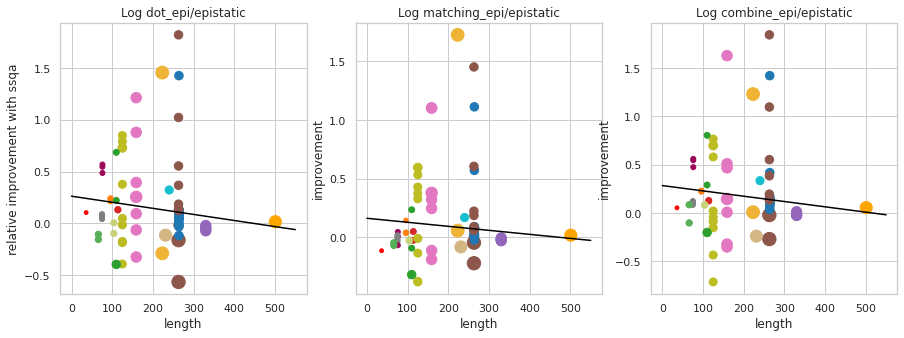

In [273]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
clf = HuberRegressor()
clf.fit(rho_df["length"].values[:,None], np.log(rho_df["dot_epi"]/rho_df["epistatic"]), rho_df["size"])
x = np.linspace(0, 550, 551)
plt.plot(x, x*clf.coef_+clf.intercept_, c="black")
plt.scatter(rho_df["length"], np.log(rho_df["dot_epi"]/rho_df["epistatic"]), color = rho_df.fam.apply(lambda x : color[x]), 
            s = rho_df["length"]/np.log10(rho_df["size"]), 
            marker = "o")
plt.xlabel("length")
plt.ylabel("relative improvement with ssqa")
plt.title("Log dot_epi/epistatic")

plt.subplot(1,3,2)
clf = HuberRegressor()
clf.fit(rho_df["length"].values[:,None], np.log(rho_df["matching_epi"]/rho_df["epistatic"]), rho_df["size"])
x = np.linspace(0, 550, 551)
plt.plot(x, x*clf.coef_+clf.intercept_, c="black")
plt.scatter(rho_df["length"], np.log(rho_df["matching_epi"]/rho_df["epistatic"]), color = rho_df.fam.apply(lambda x : color[x]), 
            s = rho_df["length"]/np.log10(rho_df["size"]), 
            marker = "o")
plt.xlabel("length")
plt.ylabel("improvement")
plt.title("Log matching_epi/epistatic")

plt.subplot(1,3,3)
clf = HuberRegressor()
clf.fit(rho_df["length"].values[:,None], np.log(rho_df["combine_epi"]/rho_df["epistatic"]), rho_df["size"])
x = np.linspace(0, 550, 551)
plt.plot(x, x*clf.coef_+clf.intercept_, c="black")
plt.scatter(rho_df["length"], np.log(rho_df["combine_epi"]/rho_df["epistatic"]), color = rho_df.fam.apply(lambda x : color[x]), 
            s = rho_df["length"]/np.log10(rho_df["size"]), 
            marker = "o")
plt.xlabel("length")
plt.ylabel("improvement")
plt.title("Log combine_epi/epistatic")

We use as a baseline the secondary structure before matching (the probability at each residue of having secondary structure $s_i$):

let $p_i(x_0)$ be the distribution for reference secondary structure at residue $i$ and $p_i(x)$ the one for sequence $x$. Then $(q_i(x_0) = ~<p_i(x_0)|p_i(x)>)_i$ is a vector of local features for secondary structure quality. By supervising on this vectors we get a new SSQA metric before matching.

We can then plot the relative enrichment $r.e. = \log(\frac{\rho_{SSQA_{matching}}}{\rho_{SSQA_{nomatching}}})$ in function of $\frac{L}{\log10(N)}$ where $L$ is the length of the reference sequence and $N$ the size of the training dataset. We then have a good correlation between the two variables by performing a linear regression. 

The matching become interesting when $\frac{L}{\log10(N)} > 91$, for example when $L = 300$ and $N < 1000$ or when $L = 200$ and $N < 100$

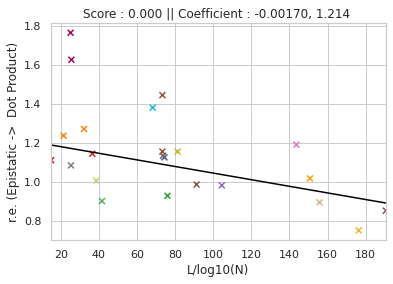

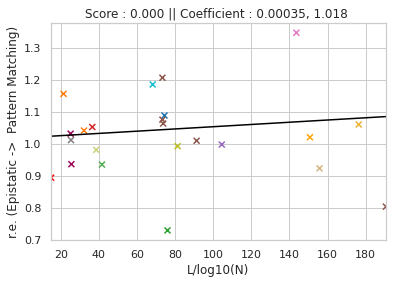

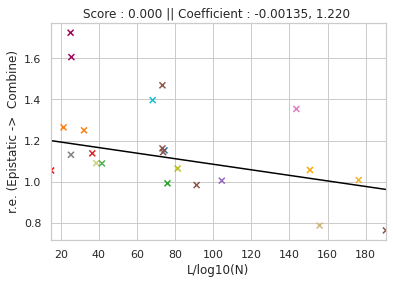

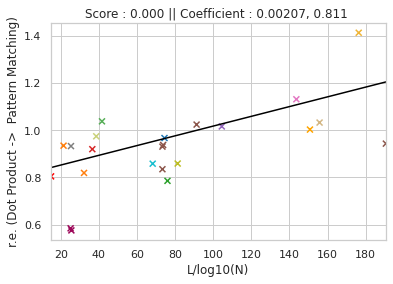

In [274]:
X = rho_df["length"].values[:,None]/np.log10(0.8*rho_df["size"].values[:,None])
X2 = rho_df2["length"].values[:,None]/np.log10(0.8*rho_df2["size"].values[:,None])
m,M = min(X),max(X)
x = np.linspace(m,M,100)

clf = HuberRegressor()
y = rho_df["dot_epi"]/rho_df["epistatic"]
y2 =  rho_df2["dot_epi"]/rho_df2["epistatic"]
clf.fit(X,y)
a, c = clf.coef_[0][None], clf.intercept_[None]
plt.plot(x, a*x+c, c="black")
plt.scatter(X2, y2, color = rho_df2.fam.apply(lambda x : color[x]), 
            marker = "x")
plt.ylabel("r.e. (Epistatic ->  Dot Product)")
plt.xlabel("L/log10(N)")
plt.xlim(m,M)
plt.title(f"Score : {0:.3f} || Coefficient : {a[0]:.5f}, {c[0]:.3f} ")
plt.show()

clf = HuberRegressor()
y = rho_df["matching_epi"]/rho_df["epistatic"]
y2 = rho_df2["matching_epi"]/rho_df2["epistatic"]

clf.fit(X,y)
a, c = clf.coef_[0][None], clf.intercept_[None]
plt.plot(x, a*x+c, c="black")
plt.scatter(X2, y2, color = rho_df2.fam.apply(lambda x : color[x]), 
            marker = "x")
plt.ylabel("r.e. (Epistatic ->  Pattern Matching)")
plt.xlabel("L/log10(N)")
plt.xlim(m,M)
plt.title(f"Score : {0:.3f} || Coefficient : {a[0]:.5f}, {c[0]:.3f} ")
plt.show()

clf = HuberRegressor()
y = rho_df["combine_epi"]/rho_df["epistatic"]
y2 = rho_df2["combine_epi"]/rho_df2["epistatic"]

clf.fit(X,y)
a, c = clf.coef_[0][None], clf.intercept_[None]
plt.plot(x, a*x+c, c="black")
plt.scatter(X2, y2, color = rho_df2.fam.apply(lambda x : color[x]), 
            marker = "x")
plt.ylabel("r.e. (Epistatic ->  Combine)")
plt.xlabel("L/log10(N)")
plt.xlim(m,M)
plt.title(f"Score : {0:.3f} || Coefficient : {a[0]:.5f}, {c[0]:.3f} ")
plt.show()


clf = HuberRegressor()
y = rho_df["matching_epi"]/rho_df["dot_epi"]
y2 = rho_df2["matching_epi"]/rho_df2["dot_epi"]

clf.fit(X,y)
a, c = clf.coef_[0][None], clf.intercept_[None]
plt.plot(x, a*x+c, c="black")
plt.scatter(X2, y2, color = rho_df2.fam.apply(lambda x : color[x]), 
            marker = "x")
plt.ylabel("r.e. (Dot Product ->  Pattern Matching)")
plt.xlabel("L/log10(N)")
plt.xlim(m,M)
plt.title(f"Score : {0:.3f} || Coefficient : {a[0]:.5f}, {c[0]:.3f} ")
plt.show()


In [266]:
-clf.intercept_/clf.coef_[0]

92.49815029067406

In [267]:
rho_df2["predicted_re"] = clf.predict((rho_df2["length"]/np.log10(0.8*rho_df2["size"])).values[:,None])
rho_df2["predicted_matching"] = rho_df2["dot_epi"] * np.exp(rho_df2["predicted_re"])
rho_df["predicted_re"] = clf.predict((rho_df["length"]/np.log10(0.8*rho_df["size"])).values[:,None])
rho_df["predicted_matching"] = rho_df["dot_epi"] * np.exp(rho_df["predicted_re"])

In [269]:
from scipy.stats import spearmanr

print(spearmanr(rho_df2["matching_epi"],rho_df2["predicted_matching"])[0])
print(spearmanr(rho_df["matching_epi"],rho_df["predicted_matching"])[0])

0.7529644268774704
0.8803120759174453


In [271]:
rho_df2[["dot_epi", "matching_epi","predicted_matching"]]

,dot_epi,matching_epi,predicted_matching
0,0.527255,0.513829,0.470286
1,0.518502,0.407272,0.500666
2,0.628654,0.505710,0.533228
3,0.629036,0.540294,0.614323
4,0.645250,0.647195,0.730176
5,0.681680,0.585062,0.647478
6,0.672733,0.618791,0.597432
7,0.674543,0.685528,0.691941
8,0.703125,0.410630,0.609512
9,0.677734,0.632244,0.587738


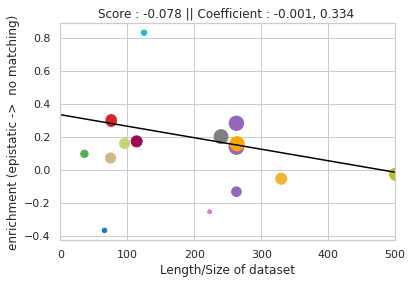

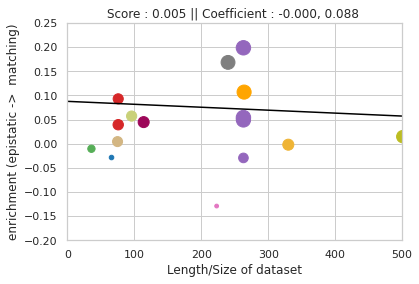

In [589]:
clf = HuberRegressor()
X = rho_df["length"].values[:,None]
y = np.log(rho_df["epistatic + ssqa_nomatch"]/rho_df["epistatic"])
clf.fit(X,y,rho_df["size"])
m,M = -100,700
x = np.linspace(m,M,100)
plt.plot(x, clf.predict(x[:,None]), c="black")
plt.scatter(X[:,0], y, color = rho_df.fam.apply(lambda x : color[x]), 
            s = 3*np.sqrt(rho_df["size"]), 
            marker = "o")
plt.ylabel("enrichment (epistatic ->  no matching)")
plt.xlabel("Length/Size of dataset")
plt.xlim(0,500)
plt.title(f"Score : {clf.score(X,y):.3f} || Coefficient : {clf.coef_[0]:.3f}, {clf.intercept_:.3f} ")
plt.show()

clf = HuberRegressor()
X = (rho_df["length"]).values[:,None]
y = np.log(rho_df["epistatic + ssqa"]/rho_df["epistatic"])
clf.fit(X,y,rho_df["size"])
m,M = -100,700
x = np.linspace(m,M,100)
plt.plot(x, clf.predict(x[:,None]), c="black")
plt.scatter(X[:,0], y, color = rho_df.fam.apply(lambda x : color[x]), 
            s = 3*np.sqrt(rho_df["size"]), 
            marker = "o")
plt.xlim(0,500)
plt.ylim(-0.2,0.25)
plt.ylabel("enrichment (epistatic ->  matching)")
plt.xlabel("Length/Size of dataset")
plt.title(f"Score : {clf.score(X,y):.3f} || Coefficient : {clf.coef_[0]:.3f}, {clf.intercept_:.3f} ")
plt.show()

In [473]:
clf.score(X,y)

0.31449006905929044

In [39]:
from sklearn.linear_model import *